<a href="https://colab.research.google.com/github/AchiniR/DM-group-project/blob/main/final_netflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# dataset
#https://www.kaggle.com/datasets/jhajalaj/netflix-india-shows-and-movies/data


# Ref
#https://www.kaggle.com/code/bansodesandeep/netflix-movies-and-tv-shows-clustering/notebook#4.-Cleaning-data

In [2]:
!pip install contractions
!pip install yellowbrick

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 4.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import contractions
import nltk
from nltk.corpus import stopwords
import string
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

In [5]:
# reading data
path = '/content/drive/MyDrive/DM_prroject/netflix_india_shows_and_movies.csv'

original_df = pd.read_csv(path,index_col='showid')
df = original_df.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6698 entries, 81607354 to 81023623
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                6698 non-null   object 
 1   type                6698 non-null   object 
 2   rating              6698 non-null   object 
 3   duration            6698 non-null   object 
 4   description         6698 non-null   object 
 5   hook_text           3165 non-null   object 
 6   genre               6698 non-null   object 
 7   release_year        6685 non-null   float64
 8   release_date        6698 non-null   object 
 9   mood_tag            6051 non-null   object 
 10  actors              6031 non-null   object 
 11  creator             1174 non-null   object 
 12  director            4260 non-null   object 
 13  audio               3998 non-null   object 
 14  subtitles           3997 non-null   object 
 15  tags                6698 non-null   object 


In [7]:
df.head()

,name,type,rating,duration,description,hook_text,genre,release_year,release_date,mood_tag,actors,creator,director,audio,subtitles,tags,similar_titles_id,production_country
showid,,,,,,,,,,,,,,,,,,
81607354,A Killer Paradox,TVSeries,A,1 Season,"When one accidental killing leads to another, ...",NaN,Thriller,2024.0,2024-2-9,Offbeat;Suspenseful,Choi Woo-shik;Son Suk-ku;Lee Hee-jun,Lee Chang-hee;Kim Da-min,NaN,NaN,NaN,Korean;Crime TV Shows;K-dramas based on Webtoo...,81444051;81461539;81011211;81640988;80990668;8...,South Korea
81616617,Ashes,Movie,A,1.6667,From an intoxicating fantasy to a dangerous af...,NaN,Drama,2024.0,2024-2-9,Psychological;Intimate;Romantic,Funda Eryiğit;Alperen Duymaz;Mehmet Günsür;Nur...,NaN,Erdem Tepegöz,English;Turkish - Audio Description;Turkish [O...,English;English;Turkish,Turkish;Dramas;Romantic Movies,81732726;81256740;81671215;81637260;81566662;8...,Turkey
81732726,Bhakshak,Movie,A,2.25,A struggling local journalist begins a dogged ...,NaN,Drama,2024.0,2024-2-9,Gritty,Bhumi Pednekar;Sanjay Mishra;Aditya Srivastava...,NaN,Pulkit,English;Hindi - Audio Description;Hindi [Origi...,English;English;Hindi,Hindi-Language Movies;Bollywood Movies;Crime M...,81671215;81637260;81725616;81637261;81740214;8...,India
81611991,"Lover, Stalker, Killer",Movie,U/A 16+,1.5,"In this twisting documentary, a mechanic tries...",NaN,Documentary,2024.0,2024-2-9,NaN,NaN,NaN,Sam Hobkinson,English - Audio Description;English [Original],English,Documentaries;Crime Movies;True Crime Document...,81671836;81130130;81620852;81607097;81212487;8...,NaN
70305903,Interstellar,Movie,U/A 13+,2.8167,With humanity teetering on the brink of extinc...,NaN,Sci-Fi,2014.0,2024-2-9,Mind-Bending;Cerebral,Matthew McConaughey;Anne Hathaway;Jessica Chas...,NaN,Christopher Nolan,English [Original],English;Hindi,Sci-Fi Movies;Dramas;Action & Adventure Movies...,70131314;81198930;80117456;80023689;80244645;8...,United States


In [8]:
# calculating missing values
missing_values = df.isnull()
total_missing_values = missing_values.sum()
print(total_missing_values)

name                     0
type                     0
rating                   0
duration                 0
description              0
hook_text             3533
genre                    0
release_year            13
release_date             0
mood_tag               647
actors                 667
creator               5524
director              2438
audio                 2700
subtitles             2701
tags                     0
similar_titles_id       11
production_country     554
dtype: int64


In [9]:
# convert to date-time
df["release_date"] = pd.to_datetime(df['release_date'])

# create seperate column for year, month, and day
df['month'] = df['release_date'].dt.month
df['year'] = df['release_date'].dt.year
df['day'] = df['release_date'].dt.day

df['day_of_week'] = df['release_date'].dt.dayofweek
df['weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [10]:
#Drop columns
df.drop('release_year',axis=1,inplace=True)
df.drop('creator',axis=1,inplace=True)
df.drop('release_date',axis=1,inplace=True)

In [11]:
df[['director','actors','production_country', 'hook_text', 'audio', 'subtitles', 'mood_tag']] = df[['director','actors','production_country', 'hook_text', 'audio', 'subtitles', 'mood_tag']].fillna('Unknown')
df[['similar_titles_id']] = df[['similar_titles_id']].fillna('None')
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])

In [12]:
# Age ratings
df.rating.unique()

array(['A', 'U/A 16+', 'U/A 13+', 'U/A 7+', 'U'], dtype=object)

In [13]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'rating' column
df["rating_encoded"] = label_encoder.fit_transform(df["rating"])

In [14]:
#one hot encoding
dummies=pd.get_dummies(df.type)

df = pd.concat([df,dummies],axis=1)

df.drop('type',axis=1,inplace=True)

In [15]:
df[df['year']==1970]

,name,rating,duration,description,hook_text,genre,mood_tag,actors,director,audio,...,similar_titles_id,production_country,month,year,day,day_of_week,weekend,rating_encoded,Movie,TVSeries
showid,,,,,,,,,,,,,,,,,,,,,
80151644,Puss in Book: Trapped in an Epic Tale,U/A 7+,0.5833,Puss in Boots has fallen into a magic book rul...,Unknown,Kids,Goofy,Eric Bauza;Jayma Mays;Maria Bamford;Jeff Benne...,Roy Burdine;Johnny Castuciano,Unknown,...,80018988;81054409;80994695;81108751;80227574;8...,United States,1,1970,1,3,0,4,1,0
80196044,The Crew,A,1.3333,"After an unexpected misstep, a crew of skilled...",French hip-hop artist Kaaris co-stars as a men...,Thriller,Gritty,Sami Bouajila;Guillaume Gouix;Youssef Hajdi;Re...,Julien Leclercq,Unknown,...,81175433;81079723;81446739;81721676;81115400;7...,France,1,1970,1,3,0,0,1,0
81031181,Goyo: The Boy General,A,2.4833,"Brash ladies' man Gregorio ""Goyo"" del Pilar ri...",Unknown,Drama,Unknown,Paulo Avelino;Carlo Aquino;Arron Villaflor;Mon...,Jerrold Tarog,Unknown,...,81726434;80141777;80218962;81687835;81268316;8...,Philippines,1,1970,1,3,0,0,1,0
81023623,Close Enemies,A,1.8333,"After an ambush leaves his partner dead, drug ...",Nominated for a Golden Lion at the Venice Film...,Drama,Gritty,Matthias Schoenaerts;Reda Kateb;Adel Bencherif...,David Oelhoffen,Unknown,...,81115400;81483371;81102814;81312798;81218770;8...,France,1,1970,1,3,0,0,1,0


In [16]:
## droping the 1970 movies as all the other movies are from 2015 to present
df.drop(df[df['year']==1970].index, axis=0,inplace=True)

In [17]:
df.genre.value_counts()

Drama               1737
Comedy              1357
Documentary          791
Kids                 642
Action               466
Thriller             356
Romance              355
Anime                287
Reality TV           259
Horror               223
Sci-Fi                85
Fantasy               65
Music                 26
Special Interest      10
Talk Show             10
Variety TV             9
Musical                7
Sports                 4
Western                4
Friendship             1
Name: genre, dtype: int64

In [18]:
# Fit and transform the 'genre' column
df["genre_encoded"] = label_encoder.fit_transform(df["genre"])

In [19]:
df.production_country.value_counts()

United States           1898
India                    866
Unknown                  554
Japan                    477
South Korea              402
United Kingdom           265
Spain                    203
Mexico                   148
Africa                   146
France                   125
China                    122
Canada                   111
Brazil                   101
Germany                   86
Indonesia                 83
Turkey                    78
Italy                     76
South Africa              76
Taiwan                    74
Poland                    69
Egypt                     68
Australia                 67
Thailand                  64
Philippines               59
Colombia                  47
Argentina                 44
Scandinavia               37
Malaysia                  34
Singapore                 27
Middle East               25
Saudi Arabia              24
Norway                    23
Netherlands               22
Vietnam                   21
Lebanon       

In [20]:
# Split tags with multiple values
tags_split = [tag.split(';') for tag in df['mood_tag'].values]

# Use MultiLabelBinarizer for one-hot encoding
mlb = MultiLabelBinarizer()
encoded_tags = pd.DataFrame(mlb.fit_transform(tags_split), columns=mlb.classes_)

In [21]:
encoded_tags.columns

Index(['Absurd', 'Adrenaline Rush', 'Bittersweet', 'Campy', 'Cerebral',
       'Charming', 'Chilling', 'Controversial', 'Dark', 'Deadpan', 'Emotional',
       'Exciting', 'Feel-Good', 'Goofy', 'Gritty', 'Heartfelt', 'Inspiring',
       'Intimate', 'Investigative', 'Mind-Bending', 'Nostalgic', 'Offbeat',
       'Ominous', 'Provocative', 'Psychological', 'Quirky', 'Raunchy',
       'Relaxing', 'Romantic', 'Scandalous', 'Scary', 'Sentimental', 'Steamy',
       'Suspenseful', 'Swoonworthy', 'Understated', 'Unknown', 'Violent',
       'Witty'],
      dtype='object')

In [22]:
#dropping unknown tags column
encoded_tags.drop('Unknown',axis=1,inplace=True)

In [23]:
encoded_tags['showid'] = df.index

In [24]:
tags_final = encoded_tags.set_index('showid')

In [25]:
df.director.value_counts()

Unknown                  2438
Raúl Campos;Jan Suter      17
Suhas Kadav                17
Rajiv Chilaka              16
Marcus Raboy               15
                         ... 
Choi Jin-seong              1
Ridha Behi                  1
Assad Fouladkar             1
Ismail Farouk               1
Rhys Thomas                 1
Name: director, Length: 3094, dtype: int64

In [26]:
# Split tags with multiple values
directors_split = [tag.split(';') for tag in df['director'].values]

# Use MultiLabelBinarizer for one-hot encoding
encoded_directors = pd.DataFrame(mlb.fit_transform(directors_split), columns=mlb.classes_)

In [27]:
column_sums = encoded_directors.sum(axis=0)

# Print the column sums
greater_than_10_columns = column_sums[column_sums >=10].index

In [28]:
selected_directors = encoded_directors[greater_than_10_columns]
#dropping unknown directors column
selected_directors.drop('Unknown',axis=1,inplace=True)

In [29]:
selected_directors['showid'] = df.index

In [30]:
directors_final = selected_directors.set_index('showid')

In [31]:
# Extract numerical part from 'duration' column
df['duration'] = df['duration'].str.extract('(\d+\.?\d*)').astype(float)

In [32]:
selected_columns = ['description','month','year','day', 'day_of_week','weekend','rating_encoded','genre_encoded' ]

# Create a new DataFrame with only the selected columns
df_trans = df[selected_columns].copy()

In [33]:
df_trans_new = pd.merge(df_trans, tags_final, left_index=True, right_index=True)
# df_trans_new = pd.merge(df_trans_new, directors_final, left_index=True, right_index=True)

In [34]:
df_trans_new.head()

,description,month,year,day,day_of_week,weekend,rating_encoded,genre_encoded,Absurd,Adrenaline Rush,...,Romantic,Scandalous,Scary,Sentimental,Steamy,Suspenseful,Swoonworthy,Understated,Violent,Witty
showid,,,,,,,,,,,,,,,,,,,,,
81607354,"When one accidental killing leads to another, ...",2,2024,9,4,0,0,17,0,0,...,0,0,0,0,0,1,0,0,0,0
81616617,From an intoxicating fantasy to a dangerous af...,2,2024,9,4,0,0,4,0,0,...,1,0,0,0,0,0,0,0,0,0
81732726,A struggling local journalist begins a dogged ...,2,2024,9,4,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
81611991,"In this twisting documentary, a mechanic tries...",2,2024,9,4,0,3,3,0,0,...,0,0,0,0,0,0,0,0,0,0
70305903,With humanity teetering on the brink of extinc...,2,2024,9,4,0,2,13,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
df_trans_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6694 entries, 81607354 to 80058424
Data columns (total 46 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   description      6694 non-null   object
 1   month            6694 non-null   int64 
 2   year             6694 non-null   int64 
 3   day              6694 non-null   int64 
 4   day_of_week      6694 non-null   int64 
 5   weekend          6694 non-null   int64 
 6   rating_encoded   6694 non-null   int64 
 7   genre_encoded    6694 non-null   int64 
 8   Absurd           6694 non-null   int64 
 9   Adrenaline Rush  6694 non-null   int64 
 10  Bittersweet      6694 non-null   int64 
 11  Campy            6694 non-null   int64 
 12  Cerebral         6694 non-null   int64 
 13  Charming         6694 non-null   int64 
 14  Chilling         6694 non-null   int64 
 15  Controversial    6694 non-null   int64 
 16  Dark             6694 non-null   int64 
 17  Deadpan          6694 

In [36]:
#  standardize the data
# Mean
X_mean = df_trans_new.mean()

# Standard deviation
X_std = df_trans_new.std()

# Standardization
Z = (df_trans_new - X_mean) / X_std

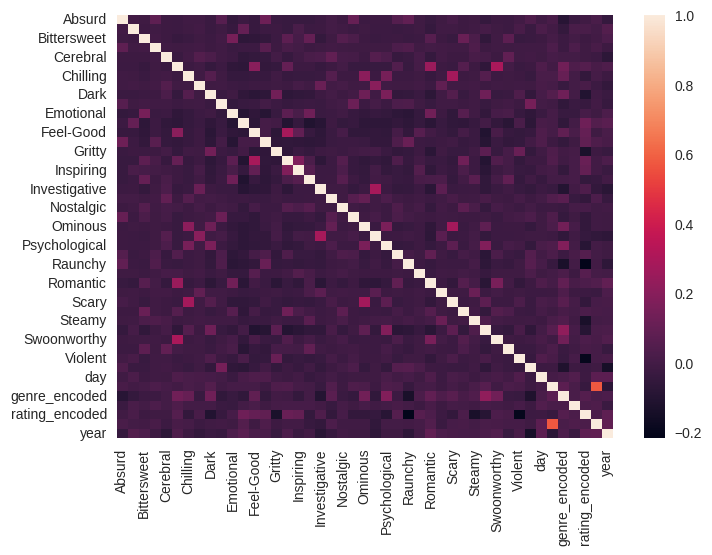

In [37]:
# covariance
c = Z.cov()

# Plot the covariance matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(c)
plt.show()

# Textual Data Preprocessing
Considered the description column

In [38]:
df_text = df_trans_new.copy()

In [39]:
## Creating new feature having length of words of description variable
df_text['description_len'] = df_text['description'].apply(lambda x: len(x.split()))

In [40]:
def contraction_process(corpus):
    '''Function which expands contractions from the corpus
    Args:
    corpus (string): corpus to which function is to be applied
    Returns:
    corpus with expanded contractions
    '''
    corpus = contractions.fix(corpus)
    return corpus

# Apply the contraction_process function to each examples in description variable
df_text['contractions_description']=df_text['description'].apply(contraction_process)
df_text.head()

,description,month,year,day,day_of_week,weekend,rating_encoded,genre_encoded,Absurd,Adrenaline Rush,...,Scary,Sentimental,Steamy,Suspenseful,Swoonworthy,Understated,Violent,Witty,description_len,contractions_description
showid,,,,,,,,,,,,,,,,,,,,,
81607354,"When one accidental killing leads to another, ...",2,2024,9,4,0,0,17,0,0,...,0,0,0,1,0,0,0,0,23,"When one accidental killing leads to another, ..."
81616617,From an intoxicating fantasy to a dangerous af...,2,2024,9,4,0,0,4,0,0,...,0,0,0,0,0,0,0,0,23,From an intoxicating fantasy to a dangerous af...
81732726,A struggling local journalist begins a dogged ...,2,2024,9,4,0,0,4,0,0,...,0,0,0,0,0,0,0,0,22,A struggling local journalist begins a dogged ...
81611991,"In this twisting documentary, a mechanic tries...",2,2024,9,4,0,3,3,0,0,...,0,0,0,0,0,0,0,0,25,"In this twisting documentary, a mechanic tries..."
70305903,With humanity teetering on the brink of extinc...,2,2024,9,4,0,2,13,0,0,...,0,0,0,0,0,0,0,0,22,With humanity teetering on the brink of extinc...


In [41]:
nltk.download('stopwords')
stopwords = stopwords.words('english')
# Displaying the English stopwords
np.array(stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [42]:
# Extracting punctuations
punctuations = string.punctuation
# Displaying the punctuations
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [43]:
def punctuation_count(txt):
    count = sum([1 for c in txt if c in punctuations])
    return 100*count/len(txt)

# Apply function to contractions_description variable
df_text['punctuation_%'] = df_text['contractions_description'].apply(lambda x: punctuation_count(x))
df_text.head()

,description,month,year,day,day_of_week,weekend,rating_encoded,genre_encoded,Absurd,Adrenaline Rush,...,Sentimental,Steamy,Suspenseful,Swoonworthy,Understated,Violent,Witty,description_len,contractions_description,punctuation_%
showid,,,,,,,,,,,,,,,,,,,,,
81607354,"When one accidental killing leads to another, ...",2,2024,9,4,0,0,17,0,0,...,0,0,1,0,0,0,0,23,"When one accidental killing leads to another, ...",2.739726
81616617,From an intoxicating fantasy to a dangerous af...,2,2024,9,4,0,0,4,0,0,...,0,0,0,0,0,0,0,23,From an intoxicating fantasy to a dangerous af...,1.315789
81732726,A struggling local journalist begins a dogged ...,2,2024,9,4,0,0,4,0,0,...,0,0,0,0,0,0,0,22,A struggling local journalist begins a dogged ...,0.735294
81611991,"In this twisting documentary, a mechanic tries...",2,2024,9,4,0,3,3,0,0,...,0,0,0,0,0,0,0,25,"In this twisting documentary, a mechanic tries...",1.360544
70305903,With humanity teetering on the brink of extinc...,2,2024,9,4,0,2,13,0,0,...,0,0,0,0,0,0,0,22,With humanity teetering on the brink of extinc...,1.418440


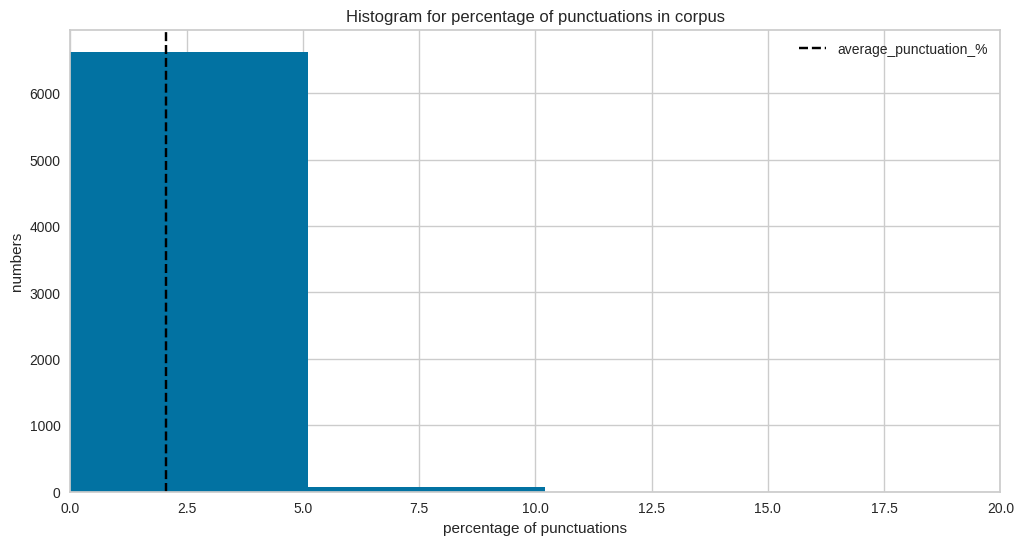

In [44]:
plt.figure(figsize=(12,6))
bins = np.linspace(0, 250, 50)

# Plot histogram
plt.hist(df_text['punctuation_%'], bins)
plt.axvline(df_text['punctuation_%'].mean(), color='black', linestyle='dashed', label='average_punctuation_%')

# Labeling to plot
plt.title('Histogram for percentage of punctuations in corpus')
plt.xlabel('percentage of punctuations')
plt.ylabel('numbers')
plt.legend(loc='best')
plt.xlim(0,20)

# Display plot
plt.show()

In [45]:
## Function to remove stopwords and punctuations and lower casing to the corpus

def remove_stopwords_punctuations(corpus):
    '''Function which removes stopwords and punctuations and lower casing to the corpus
    Args:
    corpus (string) to which function is to be applied
    Returns:
    lowercase corpus without stopwords and punctuations
    '''
    nopunc =[char for char in corpus if char not in punctuations]
    nopunc=''.join(nopunc)
    return ' '.join([word.lower() for word in nopunc.split() if word.lower() not in stopwords])

# Apply the remove_stopwords_punctuations function to each instance in variable contractions_description
df_text['no_sw_pun_description']=df_text['contractions_description'].apply(remove_stopwords_punctuations)

In [46]:
import re

def remove_URL(corpus):
    '''
    Removes URL addresses from a corpus, if present
    Args:
        corpus (string): String to which the function is to be applied
    Returns:
        clean string without URL addresses
    '''
    return re.sub(r'https?://\S+|www\.\S+', '', corpus)

# Apply the remove_URL function to each instance in variable no_sw_pun_description
df_text['clean_description']=df_text['no_sw_pun_description'].apply(remove_URL)

In [47]:
def remove_emails(corpus):
    '''
    Removes email addresses from a corpus, if present
    Args:
        corpus (string): String to which the function is to be applied
    Returns:
        clean string without email addresses
    '''
    corpus_split = corpus.split()
    return ' '.join([i for i in corpus_split if '@' not in i])

# Apply the remove_emails function to each instance in variable clean_description
df_text['clean_description']=df_text['clean_description'].apply(remove_emails)

In [48]:
from bs4 import BeautifulSoup

def remove_html_tags(corpus):
    '''
    Removes HTML-Tags from a corpus, if present
    Args:
        text (string): corpus to which the function is to be applied,
    Returns:
        Clean corpus without HTML-Tags
    '''
    return BeautifulSoup(corpus, 'html.parser').get_text()

# Apply the remove_html_tags function to each instance in variable clean_description
df_text['clean_description']=df_text['clean_description'].apply(remove_html_tags)

In [49]:
def remove_special_char(corpus):
    """Remove Special Characters from the corpus, if present
    args:
    corpus (string): corpus to which a function is to be applied
    return:
    clean corpus without  special characters
    """
    return re.sub(r"[^a-zA-Z0-9]"," ",corpus)

# Apply the remove_special_char function to each instance in variable clean_description
df_text['clean_description']=df_text['clean_description'].apply(remove_special_char)

In [50]:
def remove_digits(corpus):
    '''
    Removes digits from a corpus, if present
    Args:
        corpus (string): corpus to which the function is to be applied
    Returns:
        Clean string without digits
    '''
    return re.sub('\w*\d\w*','',corpus)

# Apply the remove_digits function to each instance in variable clean_description
df_text['clean_description']=df_text['clean_description'].apply(remove_digits)

In [51]:
def remove_extra_whitespaces(corpus):
    '''
    Removes extra whitespaces from a corpus, if present
    Args:
        text (string): corpus to which the function is to be applied
    Returns:
        Clean string without extra whitespaces
    '''
    return re.sub(r'^\s*|\s\s*', ' ', corpus).strip()

# Apply the remove_extra_whitespaces function to each instance to variable clean_description
df_text['clean_description']=df_text['clean_description'].apply(remove_extra_whitespaces)

In [52]:
nltk.download('punkt')

def tokenization_fun(corpus):
    '''
    Function tokenize corpus
    Args:
        corpus (string): corpus to which the function is to be applied
    Returns:
        tokenised corpus
    '''
    return nltk.word_tokenize(corpus)

# Apply the tokenization_fun function to each instance in variable clean_description
df_text['tokenized_description']=df_text['clean_description'].apply(tokenization_fun)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [53]:
from nltk.stem.porter import PorterStemmer

# Create object for stemming
porter_stemmer = PorterStemmer()

# Creating function for stemming
def stemming(tokenized_text):
    '''Function which stem each word in token'''
    text = [porter_stemmer.stem(word) for word in tokenized_text]
    return text

In [54]:
from nltk.stem import WordNetLemmatizer

# Download all nltk corpuses
nltk.download('wordnet')
nltk.download('omw-1.4')

# Create object for lemmatization
lemmatizer = WordNetLemmatizer()

# Creating function for lemmatization
def lemmatization(tokenized_text):
    '''Function which lemmatize each word in token'''
    text = [lemmatizer.lemmatize(word, pos="v") for word in tokenized_text]
    return text

# Apply the lemmatization function to each instance in variable tokenized_description
df_text['lemmatized_description'] = df_text['tokenized_description'].apply(lambda x : lemmatization(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [55]:
df_text['final_description'] = df_text['lemmatized_description'].apply(lambda x: ' '.join(x))

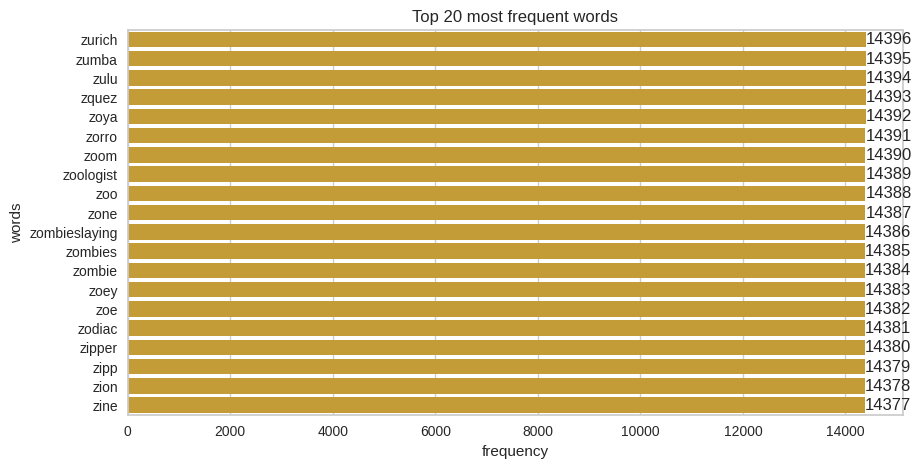

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer()

# Fit the vectorizer using the text data
X = tfid_vectorizer.fit(df_text['final_description'])

# Collect the vocabulary items used in the vectorizer
dictionary = X.vocabulary_.items()

## Bar plot of top words after cleaning text

# Lists to store the vocab and counts
vocab = []
count = []

# Iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)

# Store the count in panadas dataframe with vocab as index
vocab_count_df = pd.Series(count, index=vocab)

# Sort the dataframe
vocab_count_df= vocab_count_df.sort_values(ascending=False)

# Top 20 vocab
top_vacab = vocab_count_df.head(20)

# Plot of the top 20 vocab
plt.figure(figsize=(10,5))
ax=sns.barplot(y=top_vacab.index, x=top_vacab.values, color='goldenrod')
ax.set_title('Top 20 most frequent words')
ax.set_xlabel('frequency')
ax.set_ylabel('words')
ax.bar_label(ax.containers[0])
plt.show()

In [57]:
# Create the object of tfid vectorizer
vectorizer=TfidfVectorizer(max_features = 10000)

# Fit the vectorizer using the text data
X_tfidf = vectorizer.fit_transform(df_text['final_description'])


In [58]:
vector = pd.DataFrame(X_tfidf.toarray(), columns = vectorizer.get_feature_names_out(), index=df_trans_new.index)
vector.head()

,aamir,aaron,abandon,abbey,abby,abduct,abduction,abductors,abilities,ability,...,zombies,zombieslaying,zone,zoo,zoologist,zoom,zorro,zoya,zquez,zulu
showid,,,,,,,,,,,,,,,,,,,,,
81607354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81616617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81732726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81611991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70305903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
pca = PCA()
pca.fit(vector)

PCA()

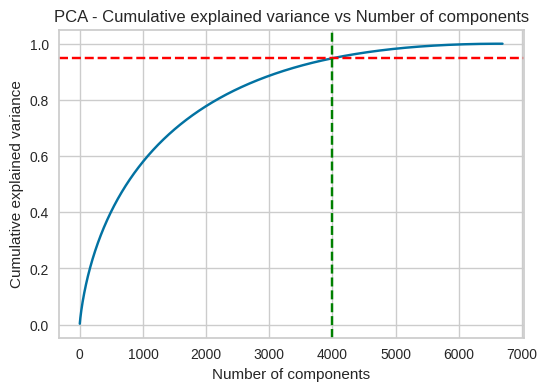

In [60]:

plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA - Cumulative explained variance vs Number of components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axhline(y= 0.95, color='red', linestyle='--')
plt.axvline(x= 4000, color='green', linestyle='--')
plt.show()

In [61]:
pca = PCA(n_components=4000)
pca.fit(vector)
X_description = pca.transform(vector)
X_description.shape

(6694, 4000)

In [62]:
X_description_df = pd.DataFrame(X_description, index=df_trans_new.index)

In [63]:
df_trans_new.drop('description', axis=1,inplace=True)

In [64]:
X = pd.merge(df_trans_new, X_description_df, left_index=True, right_index=True)

In [65]:
X.columns = X.columns.astype(str)

In [66]:
X_test = pd.DataFrame(X.iloc[4]).transpose().astype(X.dtypes)
X_test

,month,year,day,day_of_week,weekend,rating_encoded,genre_encoded,Absurd,Adrenaline Rush,Bittersweet,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
70305903,2,2024,9,4,0,2,13,0,0,0,...,0.000472,-0.005948,-0.006449,-0.006234,0.000077,0.016636,-0.009377,-0.007323,0.003247,0.005403


In [67]:
X_train = X.drop(index=70305903)

In [68]:
X_train

,month,year,day,day_of_week,weekend,rating_encoded,genre_encoded,Absurd,Adrenaline Rush,Bittersweet,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
showid,,,,,,,,,,,,,,,,,,,,,
81607354,2,2024,9,4,0,0,17,0,0,0,...,0.000441,-0.008889,0.006668,-0.005870,0.006396,-0.002688,-0.003150,-0.003363,0.001343,-0.001645
81616617,2,2024,9,4,0,0,4,0,0,0,...,-0.005327,-0.000584,0.002138,-0.003331,0.004883,0.010584,0.003882,0.001237,-0.007917,0.007706
81732726,2,2024,9,4,0,0,4,0,0,0,...,0.002904,0.005006,-0.004312,-0.003880,0.000561,-0.006005,-0.003443,0.005593,0.001639,0.002698
81611991,2,2024,9,4,0,3,3,0,0,0,...,0.006001,0.002699,-0.002914,-0.000473,0.007038,-0.003459,-0.004287,0.001128,-0.006397,-0.011677
81749227,2,2024,8,3,0,4,3,0,0,0,...,0.003211,-0.019237,-0.009189,-0.002275,0.000352,-0.006909,-0.004264,0.001198,0.001489,0.013342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80046348,11,2015,6,4,0,1,8,0,0,0,...,0.001468,0.002562,0.001511,0.006908,0.003747,-0.006272,-0.001217,0.000732,-0.001715,0.000383
70308278,11,2015,30,0,0,4,3,0,0,0,...,-0.004601,-0.004561,-0.014680,0.005034,0.008177,-0.004480,-0.002767,0.001746,0.005256,-0.002244
70264888,11,2015,16,0,0,0,4,0,0,0,...,0.006233,-0.002848,-0.008499,-0.004249,0.002352,-0.000308,-0.000891,0.000088,0.000999,0.008024


# Model building

In [69]:
X_train.shape


(6693, 4045)

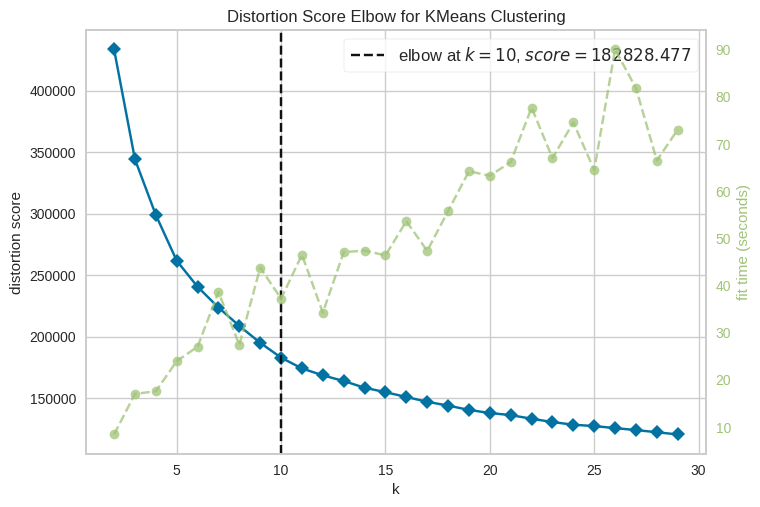

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [70]:
KMeans_model = KMeans(random_state=42)
elb_visualizer = kelbow_visualizer(KMeans_model, X, k=(2,30), locate_elbow=True)

# Display figure
elb_visualizer.show()

In [71]:
kmeans = KMeans(n_clusters=10, init='k-means++', random_state= 42)
kmeans.fit(X_train)

KMeans(n_clusters=10, random_state=42)

In [ ]:
clusters_kmeans= kmeans.predict(X_train)

In [73]:
clusters_kmeans

array([9, 1, 1, ..., 2, 2, 2], dtype=int32)

In [74]:
# Calculate evaluation metrics 0.015
print('~~'*45)
print('Evaluation result :\n')
silhouette = silhouette_score(X_train, clusters_kmeans)
ch_score = calinski_harabasz_score(X_train, clusters_kmeans)
db_score = davies_bouldin_score(X_train, clusters_kmeans)

# Print the results
print(f"Number of clusters: {len(set(clusters_kmeans))}")
print(f"Silhouette score: {silhouette}")
print(f"Calinski-Harabasz score: {ch_score}")
print(f"Davies-Bouldin score: {db_score}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Evaluation result :

Number of clusters: 10
Silhouette score: 0.21431020334730236
Calinski-Harabasz score: 2789.246820376213
Davies-Bouldin score: 1.3639734575291957


In [75]:
cluster_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

In [76]:
similarity_matrix = cosine_similarity(X_train, cluster_centroids)

In [77]:
similarity_matrix_df = pd.DataFrame(similarity_matrix)

In [78]:
def recommend_for_new_movie(new_movie_features, clustering_model, similarity_matrix, df):
    # Step 1: Cluster Assignment
    cluster_index = clustering_model.predict(new_movie_features)[0]

    # Step 2: Retrieve Recommendations from Cluster
    cluster_indices = [i for i, label in enumerate(clustering_model.labels_) if label == cluster_index]
    similarity_scores = similarity_matrix.iloc[cluster_indices]
    mean_similarity_scores = similarity_scores.mean(axis=1)

    # Step 3: Get top-10 recommendations
    top_ten_recommendations_indices = mean_similarity_scores.argsort()[-10:][::-1]

    results = df.iloc[top_ten_recommendations_indices.index]

    return results[['name', 'type']]

In [79]:
# DF for recommendations
df_rec = original_df.copy()
df_rec["release_date"] = pd.to_datetime(df_rec['release_date'])

df_rec['year'] = df_rec['release_date'].dt.year
df_rec.drop(df_rec[df_rec['year']==1970].index, axis=0,inplace=True)
df_rec.drop(index=70305903, inplace=True)
df_rec = df_rec.reset_index()

In [80]:
# Find similar Movies or TV series for "Interstellar"
recommend_for_new_movie(X_test, kmeans, similarity_matrix_df,df_rec )

,name,type
6674,Sense8,TVSeries
6579,Miss in Kiss,TVSeries
6577,White Rabbit Project,TVSeries
6575,Spectral,Movie
6559,House of Cards,TVSeries
6555,Terrace House: Boys & Girls in the City,TVSeries
6450,The Killer,Movie
6434,The Big Family Cooking Showdown,TVSeries
6433,6 Days,Movie
6429,The Sinner,TVSeries
